#Litterature review

Climate simulations methods combining physics and machine learning (ML) offer faster and cost effective ways to achieve high-resolution simulations by using ML emulators.

This mini capstone project is motivated by the work presented in ClimSim - a dataset for parameterization emulators trained on high-resolution data from
small-scale embedded models. A unique initiative compared to other benchmark datasets designed for emulators in climate simulation. ClimSim is unique for its focus on learning ML parameterizations which can be used in hybrid climate simulations. Unlike other datasets, ClimSim is designed to capture the
nonlinear effects of clouds, rain, storms, and radiation at kilometer scales [See reference](https://arxiv.org/pdf/2306.08754)



## Baseline models

ClimSim presents a regression problem with mapping from a
multivariate input vector to a multivariate target output vector y ∈ $R^d$

In the [ClimSim reference paper](https://arxiv.org/pdf/2306.08754), six baseline models used in the experiments are presented at a high level.

1.   Multi-layer Perceptron (MLP)
2.   Convolutional Neural Network (CNN)
3.   Encoder-Decoder (ED)
4.   Heteroskedastic Regression (HSR)
5.   Randomized Prior Network (RPN)
6.   Conditional Variational Autoencoder (cVAE)

The top [solutions for this problem on Kaggle](https://www.kaggle.com/competitions/leap-atmospheric-physics-ai-climsim/discussion/523063) are also based on MLP.



# Our Approach

For our capstone project, we decided to use a multi-level percenptron (MLP) approach. We made the choice based on the simplicity of the architecture and implementation.
Below we details the implentation


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libs and setup parameters

In [3]:
%%capture

import numpy as np
import pandas as pd
import polars as pl

import os
import time

from numpy import random

import matplotlib.pyplot as plt
import seaborn as sns


# configs and params
MY_SEED = 43
TRAINING_SAMPLE_NBR_ROWS =1_000_000
MY_COLORS = ('darkblue','darkgreen','darkred')

pd.set_option('display.max_columns', None) # display all columns


# Set Google Drive as working directory.

# the base Google Drive directory
root_dir = "/content/drive/MyDrive/"
# location for the project files to be saved
project_working_dir = "leap_sim_project"

# input folder of dataset
dataset_input_zip_folder = root_dir + '/Kaggle/leap-atmospheric-physics-ai-climsim.zip'
train_data_file_name = 'train.csv'
test_data_file_name = 'test.csv'
submission_data_file_name = 'sample_submission.csv'

## Helper methods

In [4]:
from zipfile import ZipFile as zipfile

def create_and_set_working_directory(project_folder):
    # check if your project folder exists. if not, it will be created.
    if os.path.isdir(root_dir + project_folder) == False:
        os.mkdir(root_dir + project_folder)
        print(root_dir + project_folder + ' did not exist but was created.')

    # change the OS to use your project folder as the working directory
    os.chdir(root_dir + project_folder)

create_and_set_working_directory(project_working_dir)

# method to read a dataset from a zipped folder
def read_dataset(dataset_input_zip_folder, train_data_file_name, nbr_rows=1, cols=None):
    with zipfile(dataset_input_zip_folder) as z:
        with z.open(train_data_file_name) as f:
            df = pd.read_csv(f, nrows = nbr_rows, usecols=cols)
    return df

# Composit features
In this section composit features are isolated.


1.   The variables with multiple dimensions are referred to as composit features. Each composit feature is composed of its 60 dimensional features
2.   The scaler variables are grouped together and referred to as scaler feature.

In [5]:
# sample the data
import re

# parse columns' names of the input/output variables
# input features are categorized as composit and scaler
# composit ones are the with multiple dimensions
# the scaler ones are grouped together

df_submission_columns = read_dataset(dataset_input_zip_folder, submission_data_file_name, 0)

targets = df_submission_columns.columns.to_list()
targets.remove('sample_id')
target_scalers_cols = targets
target_composits_cols = list()

target_composits = "ptend_t,ptend_q0001,ptend_q0002,ptend_q0003,ptend_u,ptend_v".split(",")

all_elts_of_composit_targets = dict()
for pattern in target_composits:
    all_elts_of_composit_targets[pattern] = [x for x in targets if re.match(pattern + "_[0-9]+$",x)]
    target_scalers_cols = [x for x in target_scalers_cols if x not in all_elts_of_composit_targets[pattern]]
    target_composits_cols.extend(all_elts_of_composit_targets[pattern]) # keep a list of all columns

# features
df_train_columns = read_dataset(dataset_input_zip_folder, train_data_file_name, 0)

features = [x for x in df_train_columns.columns.tolist() if x not in ['sample_id']+targets]
feature_scalers_cols = features
feature_composits_cols = list()

feature_composits = "state_t,state_q0001,state_q0002,state_q0003,state_u,state_v,pbuf_ozone,pbuf_CH4,pbuf_N2O".split(",")

all_elts_of_composit_features = dict()
for pattern in feature_composits:
    all_elts_of_composit_features[pattern] = [x for x in features if re.match(pattern + "_[0-9]+$",x)]
    feature_scalers_cols = [x for x in feature_scalers_cols if x not in all_elts_of_composit_features[pattern]]
    feature_composits_cols.extend(all_elts_of_composit_features[pattern])

# Import PCs and target variables
In the EDA, we transformed the inupt data into principal components. Below the PCs are loaded from parquet files

In [6]:
def load_data (root_dir, project_dir, file_name, feature_name):
    df = pd.read_parquet(root_dir + project_dir + '/' + file_name)
    df.columns = [feature_name + '_' + str(col) for col in df.columns]
    return df


df_train = dict()
for feature_name in feature_composits:
    print("Loading pcs of composit feature ", feature_name)
    df_train[feature_name] = load_data(root_dir, project_working_dir, 'composit_feature_' + feature_name + '_df.parquet', feature_name)


df_train["scaler"] = load_data(root_dir, project_working_dir, 'scaler_features_df.parquet', 'scaler')

df_output = load_data(root_dir, project_working_dir, 'outputs_df.parquet', '')



Loading pcs of composit feature  state_t
Loading pcs of composit feature  state_q0001
Loading pcs of composit feature  state_q0002
Loading pcs of composit feature  state_q0003
Loading pcs of composit feature  state_u
Loading pcs of composit feature  state_v
Loading pcs of composit feature  pbuf_ozone
Loading pcs of composit feature  pbuf_CH4
Loading pcs of composit feature  pbuf_N2O


# Modeling Approach

First define the custom R2 metric to measure the performance of the model

In [7]:
import tensorflow as tf

# Define custom R-squared metric
class R2Metric(tf.keras.metrics.Metric):
    def __init__(self, name='r_squared', **kwargs):
        super(R2Metric, self).__init__(name=name, **kwargs)
        self.sse = self.add_weight(name='sse', initializer='zeros')
        self.sst = self.add_weight(name='sst', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Residual sum of squares (sse)
        sse = tf.reduce_sum(tf.square(y_true - y_pred))

        # Total sum of squares (sst)
        sst = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))

        # Update the states
        self.sse.assign_add(sse)
        self.sst.assign_add(sst)

    def result(self):
        return 1 - (self.sse / (self.sst + tf.keras.backend.epsilon()))  # To prevent division by zero

    def reset_states(self):
        self.sse.assign(0.0)
        self.sst.assign(0.0)



## The Multi-Layer Perceptron (MLP) Model

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ state_t (InputLayer)      │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ state_q0001 (InputLayer)  │ (None, 13)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ state_q0002 (InputLayer)  │ (None, 30)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ state_q0003 (InputLayer)  │ (None, 22)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ state_u (InputLayer)      │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ state_v (InputLayer)      │ (None, 14)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pbuf_ozone (InputLayer)   │ (None, 6)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pbuf_CH4 (InputLayer)     │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pbuf_N2O (InputLayer)     │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ scaler (InputLayer)       │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 118)            │              0 │ state_t[0][0],         │
│ (Concatenate)             │                        │                │ state_q0001[0][0],     │
│                           │                        │                │ state_q0002[0][0],     │
│                           │                        │                │ state_q0003[0][0],     │
│                           │                        │                │ state_u[0][0],         │
│                           │                        │                │ state_v[0][0],         │
│                           │                        │                │ pbuf_ozone[0][0],      │
│                           │                        │                │ pbuf_CH4[0][0],        │
│                           │                        │                │ pbuf_N2O[0][0],        │
│                           │                        │                │ scaler[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 118)            │            472 │ concatenate_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 369)            │         43,911 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 385)            │        142,450 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)      

 Total params: 328,881 (1.25 MB)

 Trainable params: 328,645 (1.25 MB)

 Non-trainable params: 236 (944.00 B)

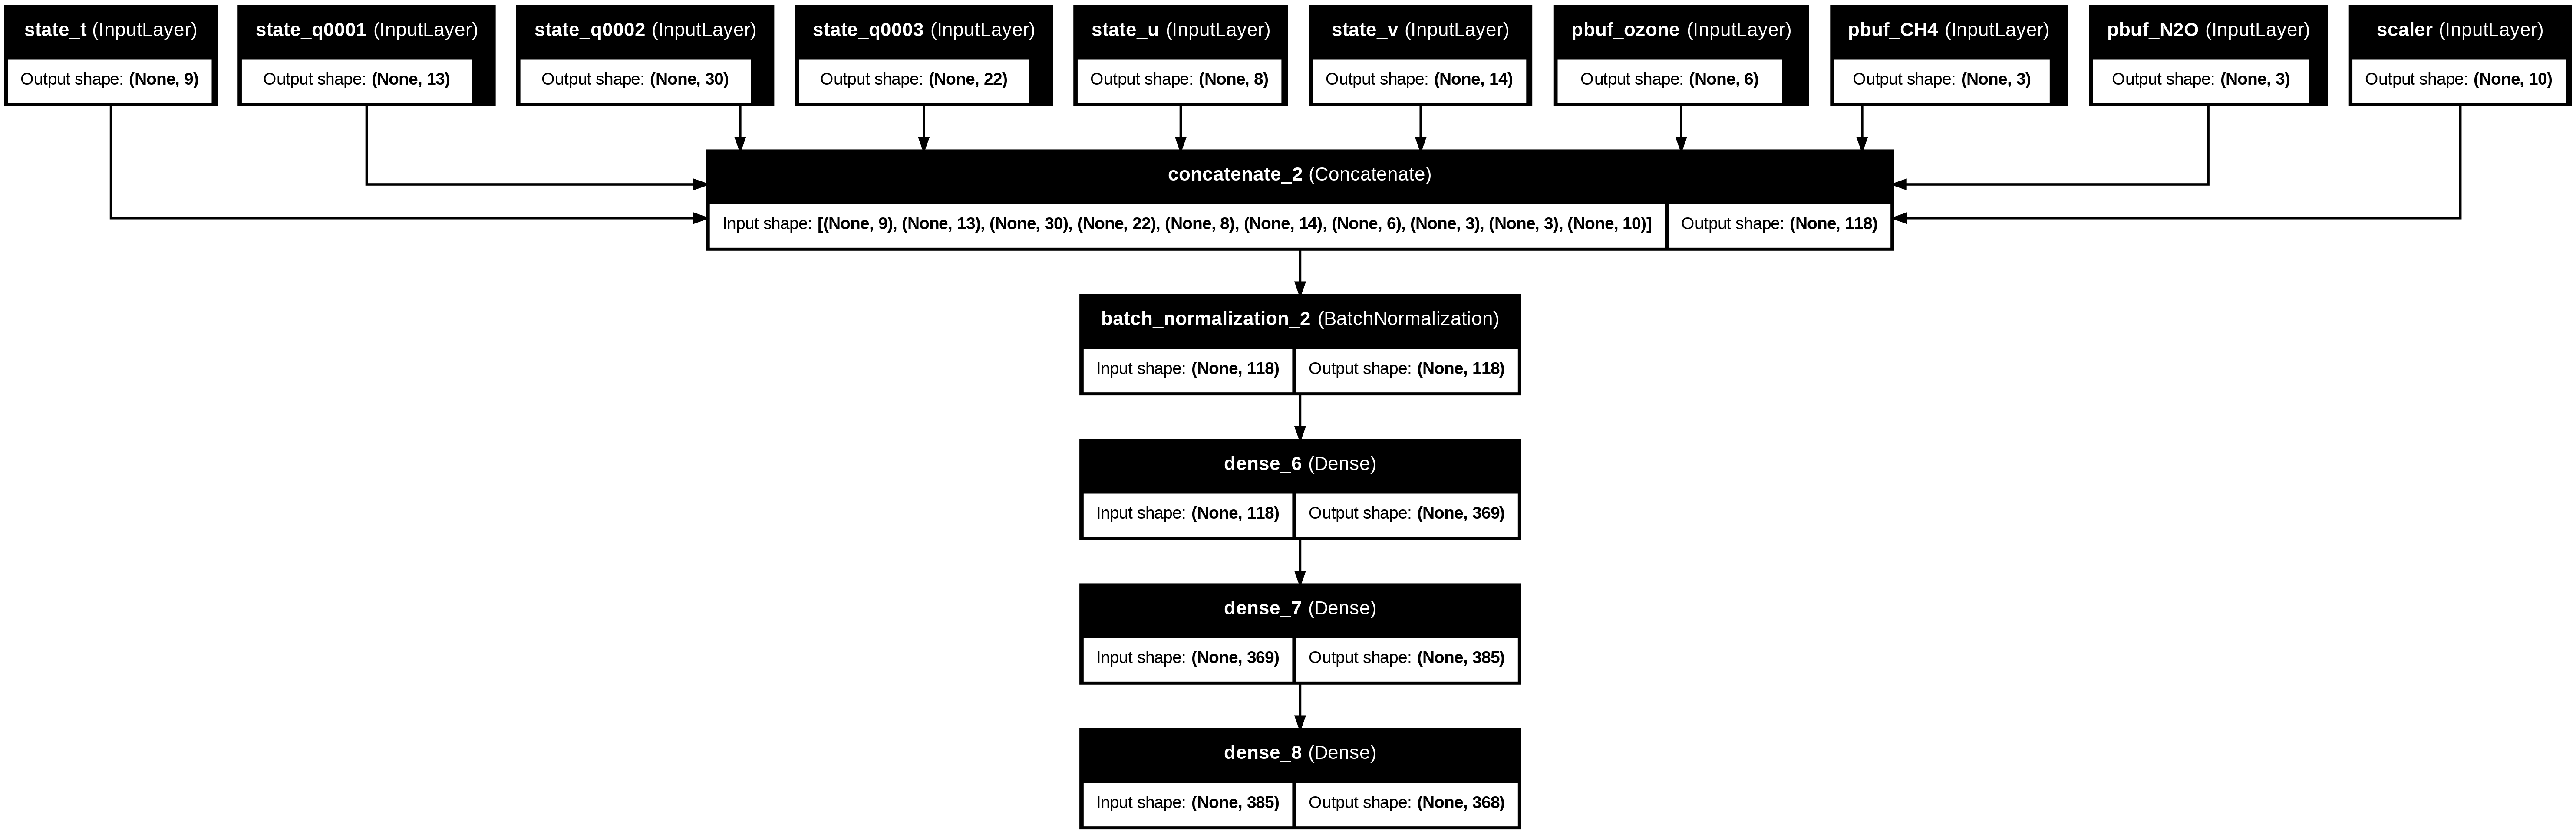

In [22]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam

from PIL import Image
from IPython.display import display

# Best hyperparameters: [0.0008468986729585612, 80, 50, 369, 2, 'relu']
"""
search_space = [
    Real(1e-4, 1e-2, "log-uniform", name='learning_rate'),  # Learning rate (log scale)
    Integer(50, 80, name='batch_size'),  # Batch size (16-128)
    Integer(30, 50, name='epochs'), # Number of epochs (10-50)
    Integer(df_output.shape[1], (df_output.shape[1]+len(feature_scalers_cols)), name='num_neurons'),  # Number of neurons per layer (32-256)
    Integer(0, 2, name='num_hidden_layers'),  # Number of hidden layers (1-3),
    Categorical(['relu', 'tanh', 'sigmoid'], name='activation')
] """

inputs = dict()
for feature_name in df_train.keys():
  inputs[feature_name] = Input(shape =(df_train[feature_name].shape[1],), name=feature_name)

# Define the uniform initializer of the weights
initializer = RandomUniform(minval=-0.1, maxval=0.1)


# input layer
input_layer = Concatenate()([inputs['state_t'],inputs['state_q0001'],inputs['state_q0002'],inputs['state_q0003'],inputs['state_u'],inputs['state_v'],inputs['pbuf_ozone'],inputs['pbuf_CH4'],inputs['pbuf_N2O'],inputs['scaler']])

# batch normalization layer
batch_norm_layer = BatchNormalization()(input_layer)

# 2 hidden layers
hidden_layer = Dense(units=369, activation='relu', kernel_initializer=initializer)(batch_norm_layer)
hidden_layer = Dense(units=369+len(feature_scalers_cols), activation='relu', kernel_initializer=initializer)(hidden_layer)
#hidden_layer = Dense(units=df_output.shape[1], activation='relu', kernel_initializer=initializer)(batch_norm_layer)
#hidden_layer = Dense(units=df_output.shape[1]+len(feature_scalers_cols), activation='relu', kernel_initializer=initializer)(hidden_layer)

# another batch normalization layer
# batch_norm_layer = tf.keras.layers.BatchNormalization()(hidden_layer)


# output layer
output_layer = Dense(units=df_output.shape[1], activation='linear', kernel_initializer=initializer)(hidden_layer)


# Create the model
model = Model(inputs=[inputs[feature_name] for feature_name in df_train.keys()], outputs=output_layer)

# Compile the model with the custom R-squared metric
# tried adagrad but was not as good as adam
optimizer = Adam(learning_rate=0.0008)
model.compile(optimizer='adam', loss='mse', metrics=[R2Metric()])

model.summary()

# Plot the model and save it as an image file
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# Display the image in the notebook
img = Image.open('model.png')
display(img)



## Fitting the model

In [23]:
state_t_input = df_train['state_t'].to_numpy()
state_q0001_input = df_train['state_q0001'].to_numpy()
state_q0002_input = df_train['state_q0002'].to_numpy()
state_q0003_input = df_train['state_q0003'].to_numpy()
state_u_input = df_train['state_u'].to_numpy()
state_v_input = df_train['state_v'].to_numpy()
pbuf_ozone_input = df_train['pbuf_ozone'].to_numpy()
pbuf_CH4_input = df_train['pbuf_CH4'].to_numpy()
pbuf_N2O_input = df_train['pbuf_N2O'].to_numpy()
scaler_input = df_train['scaler'].to_numpy()
output_input = df_output.to_numpy()


# Split Data into Training and Validation Sets
state_t_train,state_t_val,\
state_q0001_train,state_q0001_val,\
state_q0002_train,state_q0002_val,\
state_q0003_train,state_q0003_val,\
state_u_train,state_u_val,\
state_v_train,state_v_val,\
pbuf_ozone_train,pbuf_ozone_val,\
pbuf_CH4_train,pbuf_CH4_val,\
pbuf_N2O_train,pbuf_N2O_val,\
scaler_train,scaler_val,output_train,output_val = train_test_split(state_t_input,\
                   state_q0001_input,\
                   state_q0002_input,\
                   state_q0003_input,\
                   state_u_input,\
                   state_v_input,\
                   pbuf_ozone_input,\
                   pbuf_CH4_input,\
                   pbuf_N2O_input,\
                   scaler_input,\
                   output_input,\
                   test_size=0.2, random_state=42)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# define learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model with validation data
def fit_model(nbr_epochs=50, batch_size=80):
    history = model.fit([state_t_train,\
                     state_q0001_train,\
                     state_q0002_train,\
                     state_q0003_train,\
                     state_u_train,\
                     state_v_train,\
                     pbuf_ozone_train,\
                     pbuf_CH4_train,\
                     pbuf_N2O_train,\
                     scaler_train], output_train,\
                    validation_data=([state_t_val,\
                     state_q0001_val,\
                     state_q0002_val,\
                     state_q0003_val,\
                     state_u_val,\
                     state_v_val,\
                     pbuf_ozone_val,\
                     pbuf_CH4_val,\
                     pbuf_N2O_val,\
                     scaler_val], output_val),
                    epochs=nbr_epochs, batch_size=batch_size, callbacks=[early_stopping])

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot training & validation R Squared Error (R2)
    plt.plot(history.history['r_squared'])
    plt.plot(history.history['val_r_squared'])
    plt.title('Model R2')
    plt.ylabel('R Squared Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()



Epoch 1/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 40.1427 - r_squared: 0.9409 - val_loss: 6.6477 - val_r_squared: 0.9903
Epoch 2/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 7.9543 - r_squared: 0.9883 - val_loss: 5.4772 - val_r_squared: 0.9920
Epoch 3/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 7.0300 - r_squared: 0.9897 - val_loss: 5.0478 - val_r_squared: 0.9926
Epoch 4/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 6.6247 - r_squared: 0.9903 - val_loss: 4.8804 - val_r_squared: 0.9928
Epoch 5/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 6.3436 - r_squared: 0.9907 - val_loss: 4.9046 - val_r_squared: 0.9928
Epoch 6/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 6.0897 - r_squared: 0.9911 - val_loss: 4.7253 - val_r_squared: 0.9931
Epoch 7/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 5.9122 - r_squared: 0.9913 - val_loss: 4.6018 - val_r_squared: 0.9933
Epoch 8/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/st

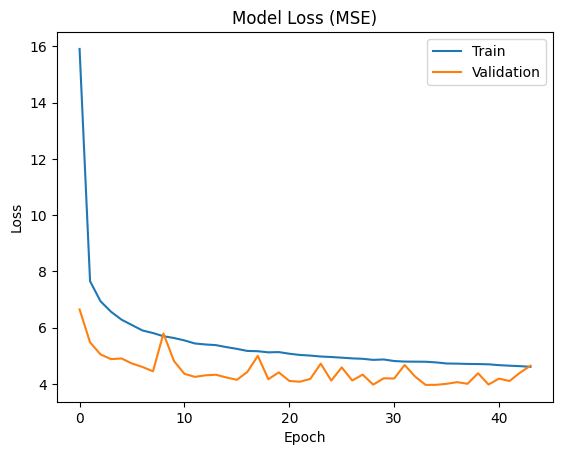

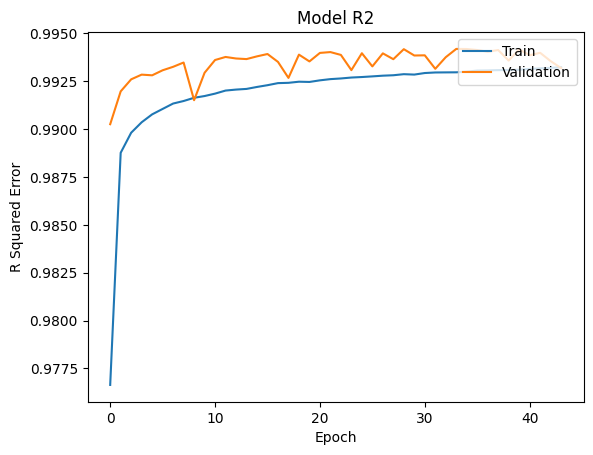

In [24]:

def cpu():
  with tf.device('/cpu:0'):
    fit_model()

def gpu():
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

  with tf.device('/device:GPU:0'):
    fit_model()

#cpu()
gpu()

In [16]:
val_loss, val_r2 = model.evaluate([state_t_val,\
                     state_q0001_val,\
                     state_q0002_val,\
                     state_q0003_val,\
                     state_u_val,\
                     state_v_val,\
                     pbuf_ozone_val,\
                     pbuf_CH4_val,\
                     pbuf_N2O_val,\
                     scaler_val], output_val)

from datetime import datetime

# Get current date and time and metrics to name the model - for perf comparison
current_datetime = datetime.now()
file_name = '/leap_sim_tf_model_' + str(current_datetime.strftime("%Y-%m-%d %H:%M")) + '_Loss_' +  str(round(val_loss,4)) + "_rootSquaredError_"+ str(round(val_mse, 4))+ ".keras"
model.save(root_dir + project_working_dir + file_name)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 3.9495 - r_squared: 0.9942


In [12]:
!nvidia-smi

Mon Oct 21 08:01:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   51C    P0              30W /  72W |   2879MiB / 23034MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--